# Calibrating cameras in space 

## Setting up workspace 

In [1]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.colors as colors
import random
import math

## User defined features 
These features should be edited based on the video and checkerboard details. 

### 1) Video details 

In [2]:
#### Video storage 
left_video_path = os.path.abspath('Add_file_path_to_left_video')
right_video_path = os.path.abspath('Add_file_path_to_right_video') 

### Folders where matched images will be stored and accessed by callibration. 
left_image_output = os.path.abspath('Add_path_to_left_image_folder') #e.g. 'Add_path_to_images/Left'
right_image_output =  os.path.abspath('Add_path_to_right_image_folder') #e.g. 'Add_path_to_images/Right'

### Video details 
video_name = 'Add_video_name'
video_fps = 30 #Add video frames per second to nearest integer 
height = 1080
width = 1920

### 2) Temporal alignment of both videos

This calibration method will use matched images from left and right cameras. One of the first stages is to split videos into a sequence of frames, and it is not necessary to use all frames of the video. This "frame_sequence" can be altered to increase or decrease the number of frames utilised in the calibration process.

In [3]:
first_camera = "Right" #add "Left" or "Right" here depending on which camera started first 
frame_offset = 24 #number of frames difference between left and right video

##For longer videos, it is recommended to take a subset of frames. 1 = take 1 frame every second, 2 = 1 image every 2 seconds. 
frame_sequence=video_fps*1 # one image every 1 second

## Select section of video when checkerboard in view. 
start_time = 5.5 #time in decimal (e.g. 5 mins 30 seconds = 5.5)
end_time = 11.25 #11 mins 15 seconds = 11.25

### 3) Checkerboard details 

In [4]:
columns = 8 #number of internal corners along horizontal dimension 
rows = 7 #number of internal corners along vertical dimension
checkerboard_box_size_scale = 33.5 #size in mm of one checkerboard square

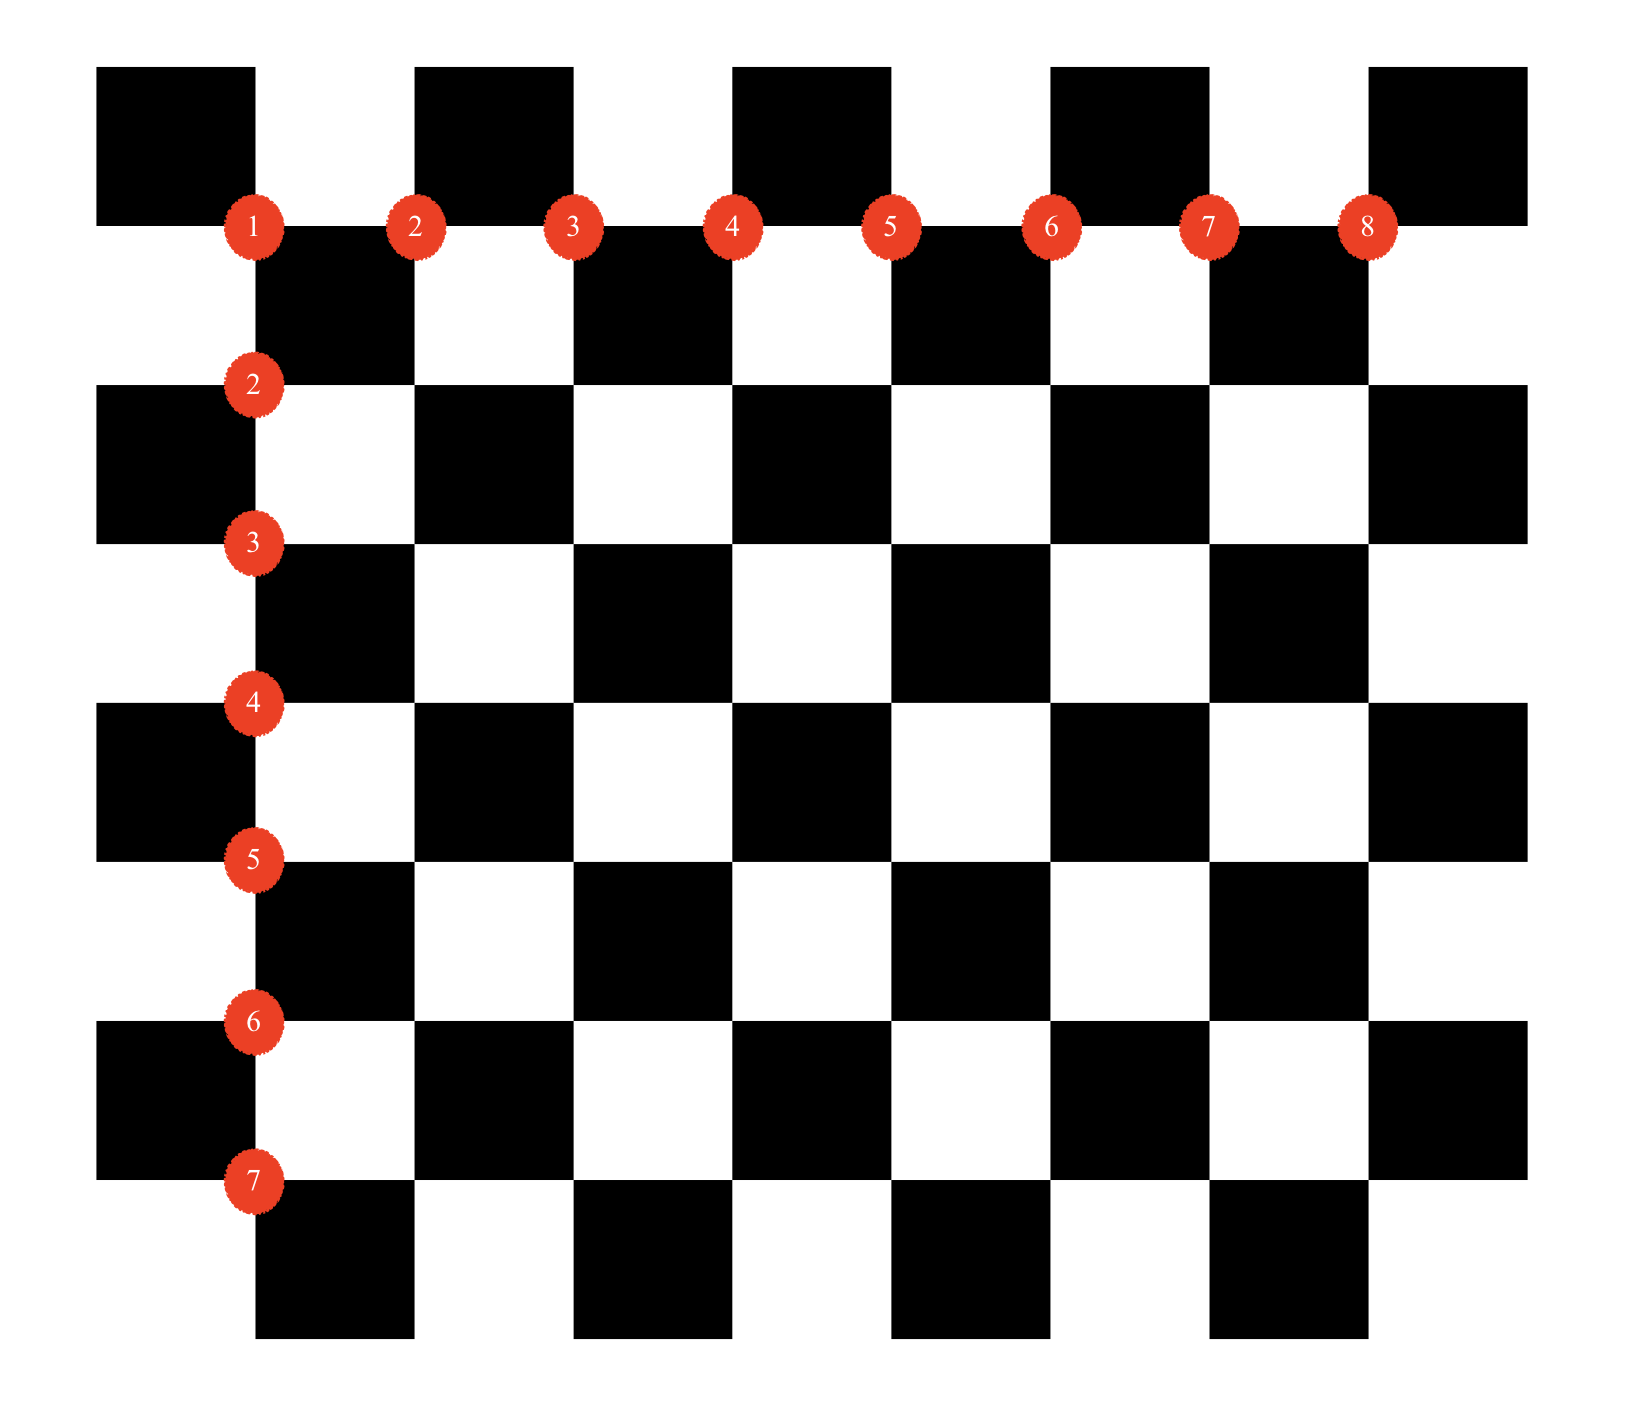

## Setting up functions 
All these functions should be run prior to calibration. 

In [5]:
def create_image_sequence(left_video_path, right_video_path):
    Frames=[]
    ## Clear any existing files in Left/Right image folders. 
    files = glob.glob('Add_path_to_images/Left/*.jpg')
    if len(files)>0:
      for f in files:
        os.remove(f)
    files = glob.glob('Add_path_to_images/Right/*.jpg')
    if len(files)>0:
      for f in files:
       os.remove(f)
    
    #Load left and right videos.  
    left_video = cv2.VideoCapture(left_video_path) 
    right_video =cv2.VideoCapture(right_video_path) 
    
    #Save matched frames
    ##Use imwrite() to save matched images to their respective folders. 
    frame_start = int(start_time*60*video_fps) # cut video to checkerboard sequence 
    frame_end = int(end_time*60*video_fps)
    
    #Set the offset - ie on which frame each video will start. This is automatically set to adjust based on whether the left or right video started first. 
    if first_camera == 'Right':
      left_offset = 0 
      right_offset = frame_offset
    else:
      left_offset = frame_offset
      right_offset = 0

    # Identify frames to be extracted (subset or full, using information provided above) 
    frame_subset =list(range(frame_start,frame_end,round(frame_sequence)))

    frame_index = 0 
    max_iteration=len(frame_subset) #number of frames to be saved (~ 20 + images)

    while frame_index <=(max_iteration-1):
        frame_id = frame_subset[frame_index] 
      #select one specified frame of the left video and read it 
        left_frameid=frame_id+left_offset
        left_video.set(1,left_frameid)
        ret, frame = left_video.read()
    #save selected frame to specified folder 
        cv2.imwrite(left_image_output+f'/Frame_{frame_index}.jpg', frame)
    #repeat for right video 
        right_video.set(1,(frame_id+right_offset))
        ret, frame = right_video.read()
    #save selected frame to specified folder 
        cv2.imwrite(right_image_output+f'/Frame_{frame_index}.jpg', frame)
        Frames.append(f'Frame_{frame_index}.jpg')
      #update iterations to move onto next frame
        frame_index = frame_index+1
        
    return(Frames)
    

In [6]:
def intrinsic_properties(image_path):
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    flag = cv2.CALIB_RATIONAL_MODEL #specifies that 6 radial distortion parameters should be used (enables k4, k5, and k6)
    
    objp = np.zeros((rows*columns,3), np.float32)
    objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
    objp = checkerboard_box_size_scale* objp

    objpoints=[] # 3d point in real world space
    imgpoints=[] # 2d points in image plane.
    framenumber=[]
    
    if(type(image_path) is str):
        images=glob.glob(image_path)
        
    if(type(image_path)is list):
        images=image_path
    
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(img, (rows, columns), cv2.CALIB_CB_ADAPTIVE_THRESH)
        #print(fname)
        
    # If found, add object points, image points (after refining them)
        if ret == True:
          objpoints.append(objp)
          framenumber.append(fname)

          corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
          imgpoints.append(corners2)

        # Draw and display the corners - unhash if user wants to see checkerboards on each image 
          #img = cv2.drawChessboardCorners(img, (rows, columns), corners2,ret)
          #cv2.imshow('img',img)
          #cv2.waitKey(500) 
          
          cv2.destroyAllWindows()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (width, height), None, None, flags=flag)
    return(ret, mtx, dist, rvecs, tvecs, objpoints, imgpoints, framenumber)

In [7]:
def reprojection_error(objpoints, rvecs, tvecs, mtx, dist, imgpoints, framenumber):
    error_result=[]
    tot_error=0
    total_points=0
    
    for i in range(len(objpoints)):
   #Calculate predicted checkerboard based on stereo calibration step above 
        reprojected_points, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    #Compare individual frame checkerboard to predicted checkerboard - produces error in pixels for each frame 
        error=np.sum(np.abs(imgpoints[i]-reprojected_points)**2)
        tot_error+=error
        total_points+=len(objpoints[i])
        error_result.append((error,len(objpoints[i]), np.sqrt(error/len(objpoints[i])), framenumber[i]))
    
    mean_error=np.sqrt(tot_error/total_points) #should be same as ret value calculated in intrinsic_properties function
    cols=['Frame_error','Object_points', 'Frame_error/Object','Frame_ID']
    error_result = pd.DataFrame(error_result, columns=cols)

    return(error_result, mean_error)

In [8]:
def refine_frames(error_result,mean_error, max_error):
    order=error_result[['Frame_error','Object_points','Frame_error/Object', "Frame_ID"]]
    order=order.sort_values(by=['Frame_error/Object'], ascending=False)
    order.index=order
    while mean_error > max_error:
        order = order.iloc[1:]
        tot_error=sum(order["Frame_error"])
        tot_points=sum(order['Object_points'])
        mean_error=np.sqrt(tot_error/tot_points)

    frames_use=order["Frame_ID"].tolist()
    return(frames_use, mean_error) 

In [9]:
def match_frames(l_frames_use, r_frames_use):
    left_frame_number=[]
    right_frame_number=[]
    for i in range(len(l_frames_use)):
        frame=l_frames_use[i]
        frame=frame.split("/")
        left_frame_number.append(frame[len(frame)-1]) 
    for i in range(len(r_frames_use)):
        frame=r_frames_use[i]
        frame=frame.split("/")
        right_frame_number.append(frame[len(frame)-1])

    frames_list=set(left_frame_number) & set(right_frame_number)
    frames_list=list(frames_list)
    
    if len(frames_list)<10:
        print("Not enough frames for calibration")
    
    l_frames_calib=[]
    r_frames_calib=[]
    for fname in frames_list:
        l_frames_calib.append(os.path.join(left_image_output, fname))
        r_frames_calib.append(os.path.join(right_image_output, fname))
    return(l_frames_calib, r_frames_calib, frames_list)

In [1]:
def extrinsic_callibration(left_image_output, right_image_output, frames_list):
   criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

   objp = np.zeros((rows*columns,3), np.float32)
   objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
   objp = checkerboard_box_size_scale* objp 
    
   objpoints = [] # 3d point in real world space
   left_imgpoints = [] # 2d points in image plane.
   right_imgpoints = [] # 2d points in image plane.
   framenumber=[]
    
   for fname in frames_list:
        
        img_l = cv2.imread(os.path.join(left_image_output,fname))
        gray_l = cv2.cvtColor(img_l,cv2.COLOR_BGR2GRAY)
        img_r = cv2.imread(os.path.join(right_image_output,fname))
        gray_r = cv2.cvtColor(img_r,cv2.COLOR_BGR2GRAY)

    # Find the checkerboard corners
        ret_l, corners_l= cv2.findChessboardCorners(gray_l, (rows, columns),None)
        ret_r, corners_r= cv2.findChessboardCorners(gray_r, (rows, columns),None)
    # If found, add object points, image points (after refining them)
        if ret_l == True & ret_r==True:
            objpoints.append(objp)
            framenumber.append(fname)
            #print(fname)

            corners2_l = cv2.cornerSubPix(gray_l,corners_l,(11,11),(-1,-1),criteria)
            left_imgpoints.append(corners2_l)
            corners2_r = cv2.cornerSubPix(gray_r,corners_r,(11,11),(-1,-1),criteria)
            right_imgpoints.append(corners2_r)

        # Draw and display the corners in matched images
            img_l = cv2.drawChessboardCorners(img_l, (rows, columns), corners2_l,ret_l)
            img_r = cv2.drawChessboardCorners(img_r, (rows, columns), corners2_r,ret_r)
            stack = np.hstack((img_l, img_r))
            cv2.imshow('Joint', stack)
            cv2.waitKey(500)
        
   cv2.destroyAllWindows()
   stereocalibration_flags = cv2.CALIB_FIX_INTRINSIC + cv2.CALIB_RATIONAL_MODEL #specifies that 6 radial distortion parameters should be used (enables k4, k5, and k6)
   ret, CM1, dist1, CM2, dist2, R, T, E, F = cv2.stereoCalibrate(objpoints, left_imgpoints, right_imgpoints, l_mtx, l_dist,r_mtx, r_dist, (width, height), criteria = criteria, flags = stereocalibration_flags)
   return(ret, CM1, dist1, CM2, dist2, R, T, E, F, left_imgpoints, right_imgpoints, framenumber)

In [11]:
def undistort_points(l_points, r_points, frame_id, l_mtx, r_mtx, l_dist, r_dist):
    
    l_points_undistort=[]
    r_points_undistort =[]
    
    for fname in frame_id:
        img_index=frame_id.index(fname)
        l_points_undistort.append(cv2.undistortPoints(l_points[img_index], l_mtx, l_dist, P=l_mtx)) 
        r_points_undistort.append(cv2.undistortPoints(r_points[img_index], r_mtx, r_dist, P=r_mtx))
        #specifying P = l_mtx/r_mtx puts points in real world points
    return(l_points_undistort, r_points_undistort, frame_id)     

In [12]:
def detect_checkerboard(l_image_path, r_image_path):
    if(type(l_image_path) is str):
        l_images=glob.glob(l_image_path)
        
    if(type(l_image_path)is list):
        l_images=l_image_path
    
    frames=[]
    for i in range(len(l_images)):
        frame=l_images[i]
        frame=frame.split("/")
        frames.append(frame[len(frame)-1])
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    objp = np.zeros((rows*columns,3), np.float32)
    objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
    objp = checkerboard_box_size_scale* objp 
    
    objpoints = [] # 3d point in real world space
    left_imgpoints = [] # 2d points in image plane.
    right_imgpoints = [] # 2d points in image plane.
    framenumber=[]
    for fname in frames:
        img_l=cv2.imread(os.path.join(left_image_output,fname))
        gray_l = cv2.cvtColor(img_l,cv2.COLOR_BGR2GRAY)
        img_r=cv2.imread(os.path.join(right_image_output,fname))
        gray_r = cv2.cvtColor(img_r,cv2.COLOR_BGR2GRAY)
        ret_l, corners_l= cv2.findChessboardCorners(gray_l, (rows, columns),None)
        ret_r, corners_r= cv2.findChessboardCorners(gray_r, (rows, columns),None)
        #If found, add object points, image points (after refining them)
        if ret_l == True & ret_r==True:
            objpoints.append(objp)
            framenumber.append(fname)
            corners2_l = cv2.cornerSubPix(gray_l,corners_l,(11,11),(-1,-1),criteria)
            left_imgpoints.append(corners2_l)
            corners2_r = cv2.cornerSubPix(gray_r,corners_r,(11,11),(-1,-1),criteria)
            right_imgpoints.append(corners2_r)
            #img_l = cv2.drawChessboardCorners(img_l, (rows, columns), corners2_l,True)
            #img_r = cv2.drawChessboardCorners(img_r, (rows, columns), corners2_r,True)
            #stack = np.hstack((img_l, img_r))
            #cv2.imshow('Joint', stack)
            #cv2.waitKey(1000)
            
    return(left_imgpoints,right_imgpoints, framenumber)    

In [13]:
def triangulate_points(l_points_undistort, r_points_undistort, frame_id, l_mtx, r_mtx, R, T):
    
    projMat1 = l_mtx @ cv2.hconcat([np.eye(3), np.zeros((3,1))]) # Cam1 is the origin
    projMat2 = r_mtx @ cv2.hconcat([R, T]) # R, T from stereoCalibrate
    frame_xyz=[]
    frame_index=[]
    
    for fname in frame_id:
        
        img_index=framenumber.index(fname)
        l_points=l_points_undistort[img_index]
        r_points=r_points_undistort[img_index]
        l_points=l_points[:,0]
        r_points=r_points[:,0]
        
        points3d=[]
        point=0
        while point < len(l_points):
            triangulation = cv2.triangulatePoints(projMat1, projMat2,l_points[point], r_points[point])
            triangulation = (triangulation[:3, :]/triangulation[3, :]).T
            points3d.append(triangulation)
            point=point+1
        frame_xyz.append(points3d)
        frame_index.append(fname)
    return(frame_xyz, frame_index)
    

In [14]:
def interpoint_distance(frame_xyz, frame_index, iteration):
    error = []
    frame_used = []
    row_diff_used =[]
    col_diff_used=[]
    dist_predict=[]
    actual_dist=[]
    
    iteration=iteration
    count=0
    
    while count < iteration:
        rand_frame_name=random.choice(frame_index)
        rand_frame=frame_index.index(rand_frame_name)

        points=frame_xyz[rand_frame]

        point1=random.choice(range(0, len(points)))
        point2=random.choice(range(0, len(points)))

        while point1 == point2:
            point1=random.choice(range(0, len(points)))
            point2=random.choice(range(0, len(points)))

        point1_coords=points[point1]
        point2_coords=points[point2]
        point1_coords=np.array([point1_coords[0][0], point1_coords[0][1], point1_coords[0][2]])
        point2_coords=np.array([point2_coords[0][0], point2_coords[0][1], point2_coords[0][2]])

        dist_predicted = np.sum((point1_coords-point2_coords)**2, axis=0)
        dist_predicted=np.sqrt(dist_predicted)

        matrix=np.arange(0, len(points), 1).reshape((rows, columns), order="F")
        result = np.where(matrix == point1)
        point_1_cols=result[1]
        point_1_rows=result[0]
        result = np.where(matrix == point2)
        point_2_cols=result[1]
        point_2_rows=result[0]

        row_diff=abs(point_2_rows-point_1_rows)
        col_diff=abs(point_2_cols-point_1_cols)

        actual = (checkerboard_box_size_scale*row_diff[0])**2 + (checkerboard_box_size_scale*col_diff[0])**2
        actual=np.sqrt(actual)

        difference=abs(dist_predicted-actual)
        dist_predict.append(dist_predicted)
        actual_dist.append(actual)
        error.append(difference)
        frame_used.append(rand_frame_name)
        row_diff_used.append(row_diff)
        col_diff_used.append(col_diff)
        count=count+1
    average_error = np.median(error) 
    return(dist_predict, actual_dist, error, frame_used, row_diff, col_diff, average_error)
   

In [15]:
def show_biggest_error(error, top_vals):

    for i in range(top_vals):
        error_result=(error, frame_used)
        max_error=sorted(set(error), key=int, reverse=True)[i]
        x=error.index(max_error)

        frame=frame_used[x]
        img_index=framenumber.index(frame)
        l_points=left_imgpoints[img_index]
        r_points=right_imgpoints[img_index]

        img_l=cv2.imread(os.path.join(left_image_output,frame))
        img_r=cv2.imread(os.path.join(right_image_output,frame))
        img_l = cv2.drawChessboardCorners(img_l, (rows, columns), l_points,True)
        img_r = cv2.drawChessboardCorners(img_r, (rows, columns), r_points,True)
        stack = np.hstack((img_l, img_r))
        cv2.imshow('Joint', stack)
        cv2.waitKey(1000)
    cv2.destroyAllWindows()

# Calibrating cameras 

In [16]:
Frames = create_image_sequence(left_video_path, right_video_path)

### Calculate left and right camera's intrinsic properties
This stage calculates properties of each camera. It also refines which frames are used in the calibration by only including those that produce a calibration accuracy of less than 1 pixel (difference in pixels between actual and predicted checkerboard).  

In [17]:
l_ret, l_mtx, l_dist, l_rvecs, l_tvecs, l_objpoints, l_imgpoints, l_framenumber=intrinsic_properties('Add_path_to_images/Left/*.jpg')
r_ret, r_mtx, r_dist, r_rvecs, r_tvecs, r_objpoints, r_imgpoints, r_framenumber=intrinsic_properties('Add_path_to_images/Right/*.jpg')

### Refine which frames are used in calibration to increase measurement accuracy  

In [18]:
# Uses camera's intrinsic properties to calculate mean reprojection error across frames. 
l_error_per_frame, l_mean_error = reprojection_error(l_objpoints, l_rvecs, l_tvecs, l_mtx, l_dist, l_imgpoints, l_framenumber)
r_error_per_frame, r_mean_error = reprojection_error(r_objpoints, r_rvecs, r_tvecs, r_mtx, r_dist, r_imgpoints, r_framenumber)

print('Left camera reprojection error before refinement =', l_mean_error)
print('Right camera reprojection error before refinement =', r_mean_error)

# Sequentially remove largest error frames until error reaches below 1 pixel. 
## This cut off can be changed by replacing the 1 below. 
l_frames_use, l_mean_error_cut = refine_frames(l_error_per_frame,l_mean_error, 1) # number = max_error (difference in pixels between actual and predicted checkerboard)
r_frames_use, r_mean_error_cut = refine_frames(r_error_per_frame,r_mean_error, 1)

# Make sure checkerboard is detected in both left and right cameras. 
l_frames_use, r_frames_use, frames_list=match_frames(l_frames_use, r_frames_use)

# Rerun callibration and re-calculate error 
l_ret, l_mtx, l_dist, l_rvecs, l_tvecs, l_objpoints, l_imgpoints, l_framenumber=intrinsic_properties(l_frames_use)
r_ret, r_mtx, r_dist, r_rvecs, r_tvecs, r_objpoints, r_imgpoints, r_framenumber=intrinsic_properties(r_frames_use)

l_error_per_frame, l_mean_error = reprojection_error(l_objpoints, l_rvecs, l_tvecs, l_mtx, l_dist, l_imgpoints, l_framenumber)
r_error_per_frame, r_mean_error = reprojection_error(r_objpoints, r_rvecs, r_tvecs, r_mtx, r_dist, r_imgpoints, r_framenumber)

print('Left camera reprojection error after refinement =', l_mean_error)
print('Right camera reprojection error after refinement =', r_mean_error)
print('Number frames = ', len(l_framenumber))

Left camera reprojection error before refinement = 2.8559184753967424
Right camera reprojection error before refinement = 2.6677315960143124
Left camera reprojection error after refinement = 0.9044783335118518
Right camera reprojection error after refinement = 0.8360199299283572
Number frames =  206


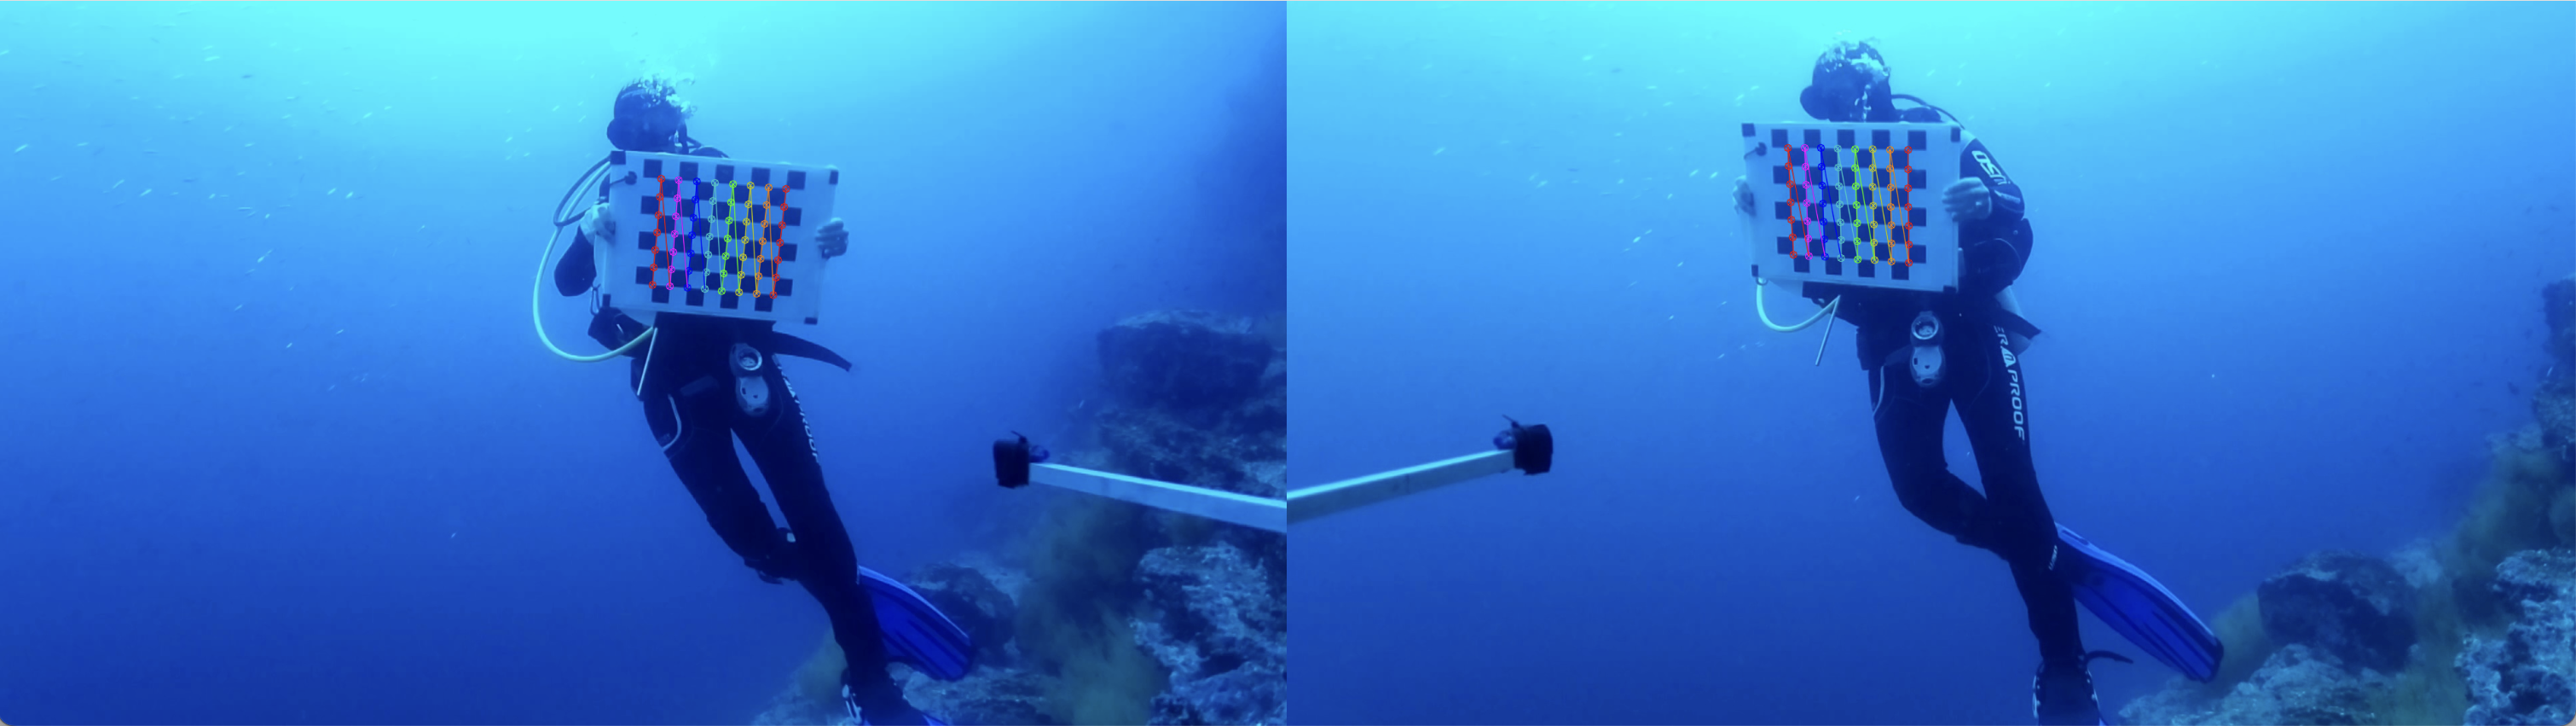

### Calculate extrinsic properties of cameras 

In [19]:
mean_error, l_mtx, l_dst, r_mtx, r_dst, R, T, E, F, left_imgpoints, right_imgpoints, frames_list = extrinsic_callibration(left_image_output, right_image_output, frames_list)

#mean_error = error for both cameras (actual vs predicted checkerboard) - will be higher than individual cameras 
#l_mtx = newCameraMatrix for left camera
#r_mtx = newCameraMatrix for right camera 
#l_dist and r_dist are the distortion coeffecients for each camera(account for radial and tangenital distortion) 

#R = Rotation matrix 
#T = transformation between two cameras
#E = essential matrix 

### Save calibration parameters for later use 

In [21]:
cv_cam=cv2.FileStorage('Add_own_file_path'+video_name+'.xml',cv2.FILE_STORAGE_WRITE)
cv_cam.write('calibration_ret', mean_error)
cv_cam.write('l_dist', l_dist)
cv_cam.write('r_dist', r_dist)
cv_cam.write('R', R)
cv_cam.write('T', T)
cv_cam.write('E', E)
cv_cam.write('F', F)
cv_cam.write('r_mtx', r_mtx)
cv_cam.write('l_mtx', l_mtx)
cv_cam.write('Video_name', video_name)
cv_cam.release()

## Checking calibration accuracy 
Calculating how accurately stereo parameters quantify known lengths of checkerboard. Inter-point distance error. 

### 1) Detect checkerboards in new image set

In [22]:
### Select new subset of frames not used in callibration 
frame_sequence=video_fps*5 # one image every 5 seconds

### Select section of video when checkerboard in view. 
#start_time = 0 #time in decimal (e.g. 5 mins 30 seconds = 5.5)
#end_time = 8 #11 mins 15 seconds = 11.5

Frames=create_image_sequence(left_video_path, right_video_path)

### Detect and store checkerboard corners in new image set
left_imgpoints,right_imgpoints, framenumber=detect_checkerboard('Add_path_to_images/Left/*.jpg', 'Add_path_to_images/Right/*.jpg')


### 2) Convert checkerboard coordinates to real world coordinates using camera parameters (undistort images to same plane)

In [23]:
l_points_undistort, r_points_undistort, frame_id=undistort_points(left_imgpoints, right_imgpoints, framenumber, l_mtx, r_mtx, l_dist, r_dist) 

### 3) Select random combinations of checkerboard points, triangulate points to determine 3D location, and calculate predicted and actual distances 

In [24]:
### Triangulate points to 3D space 
frame_xyz, frame_index= triangulate_points(l_points_undistort, r_points_undistort, frame_id, l_mtx, r_mtx, R, T)

### Calculate interpoint distance 
dist_predict, actual_dist, error, frame_used, row_diff, col_diff, average_error=interpoint_distance(frame_xyz, frame_index, 100)


### 4) Plot inter-point distance errors across multiple point combinations

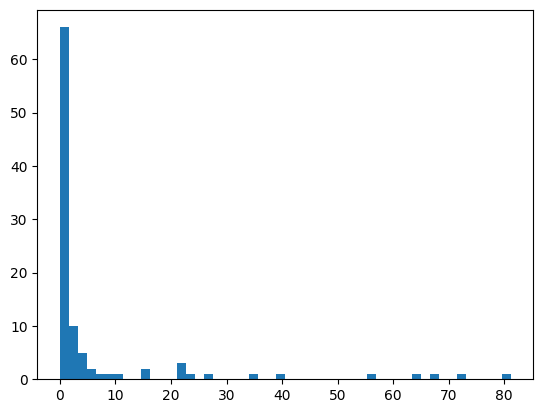

Median error for Floreana_2022-03-31_l_Cam3_r_Cam1 = 0.8629531860351562 mm


In [25]:
plt.hist(error, bins = 50) # large errors likley from poor checkerboard detections
plt.show()
print('Median error for', video_name, '=', average_error, "mm") 

### Show detected checkerboard with largest error 
show_biggest_error(error, 5) # show 5 checkerboard detections with largest mm error, likley poor checkerboard detections

### 5) Save errors to csv 

In [26]:
cv_cam=cv2.FileStorage('Add_file_path/inter-point-distance_'+video_name+'.xml',cv2.FILE_STORAGE_WRITE)
cv_cam.write('Video_name', video_name)
cv_cam.write('Error', np.array(error))
cv_cam.release()

## Checking calibration accuracy - with manual clicks 
This code randomly selects a frame and two points on the checkerboard. The user clicks on these points in both the left and right image and the code calculates the predicted (based on camera calibration) versus actual (based on known checkerboard dimensions) distance between the two points. 

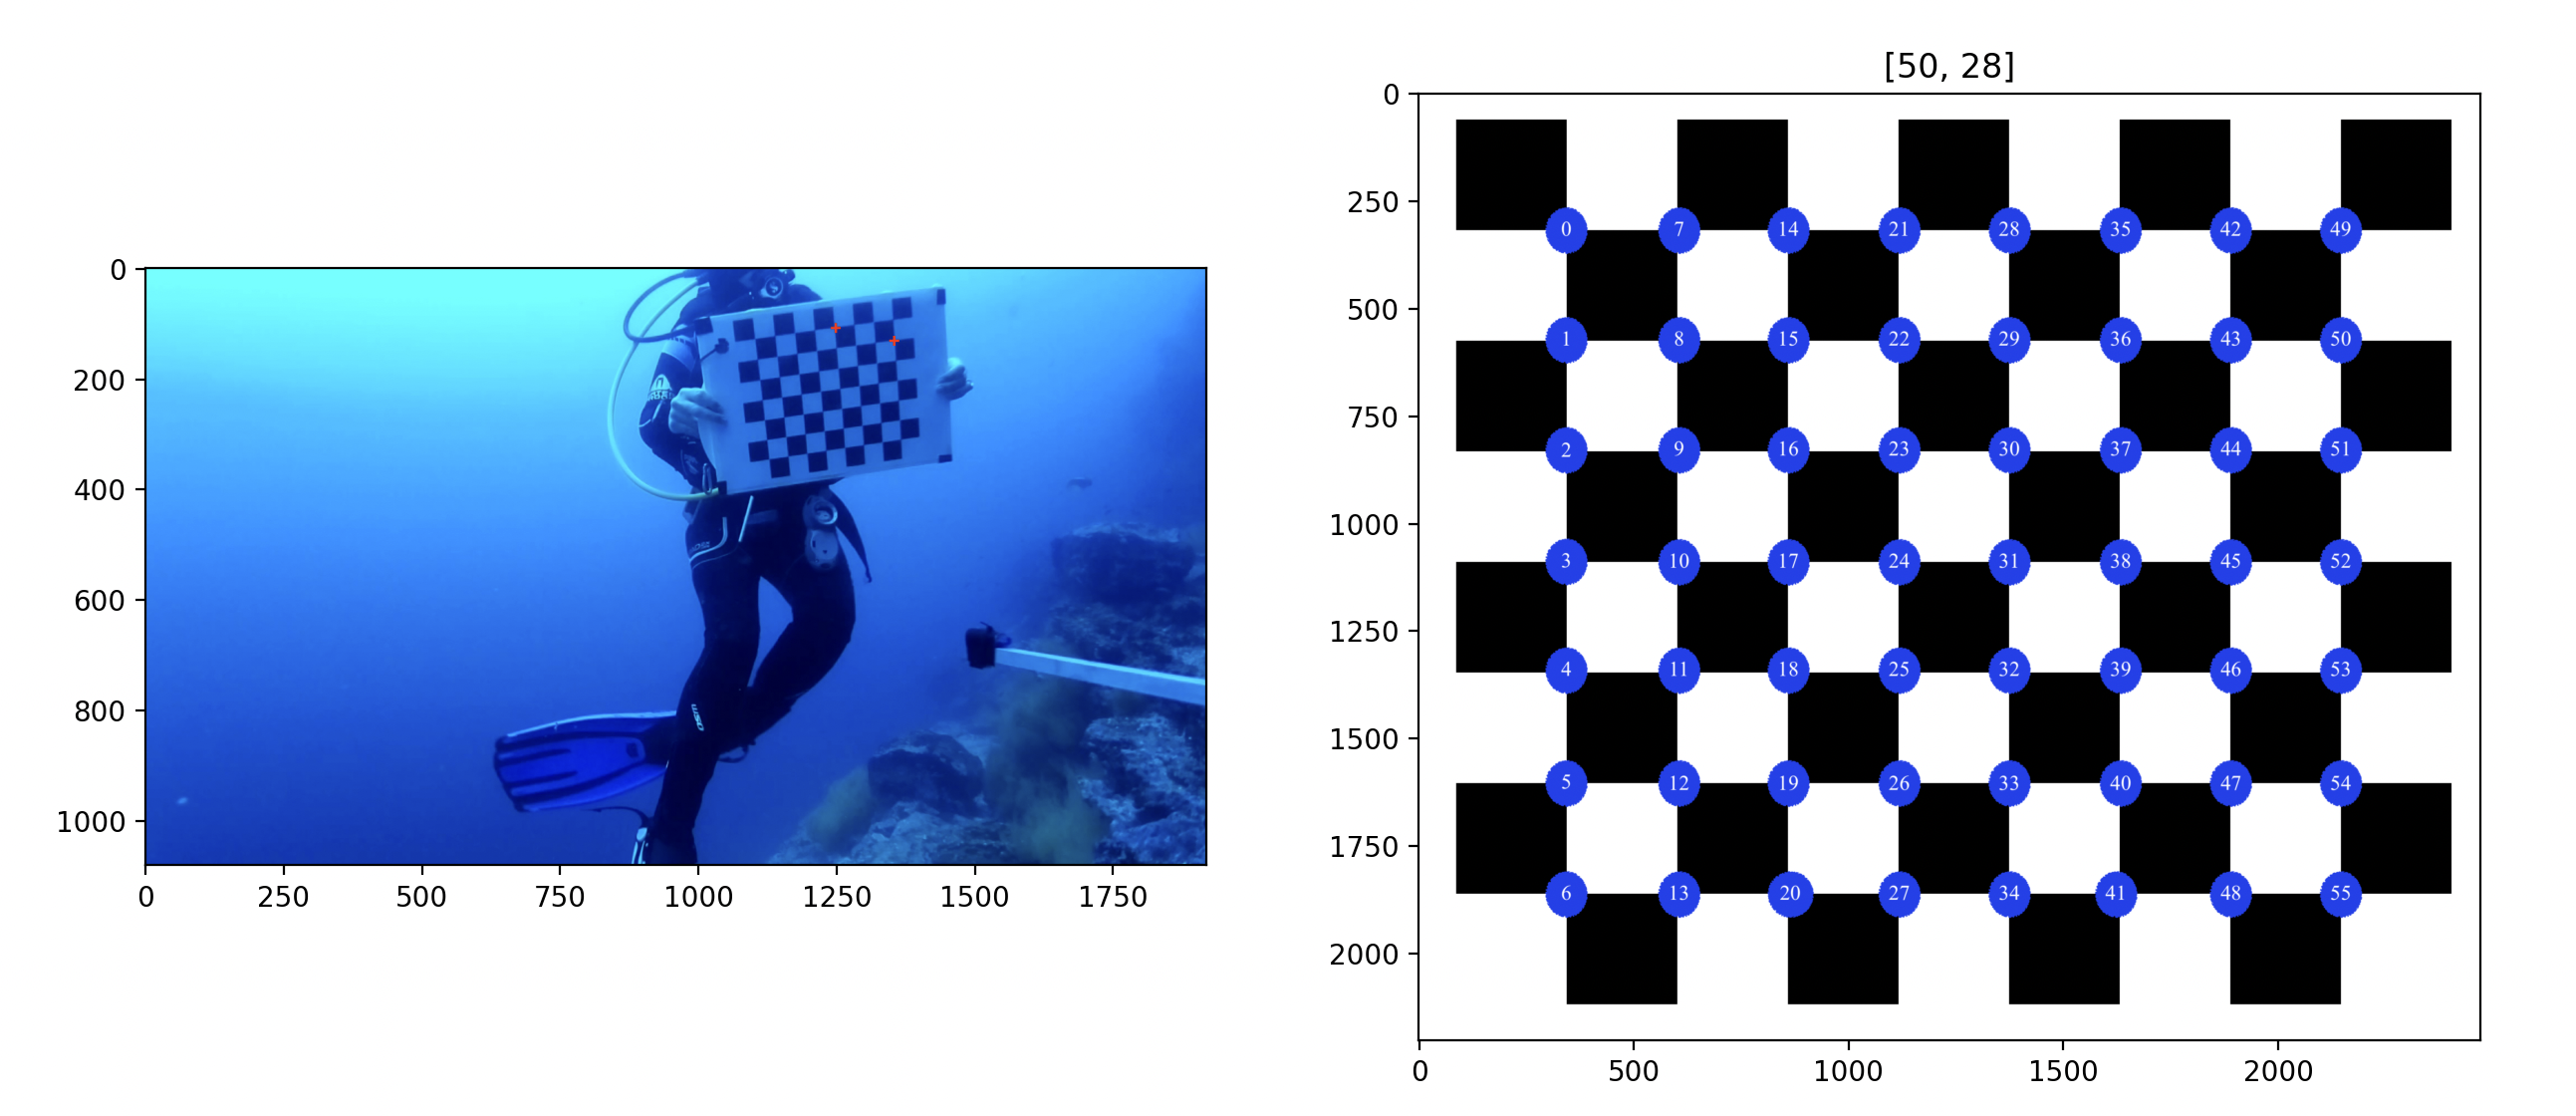

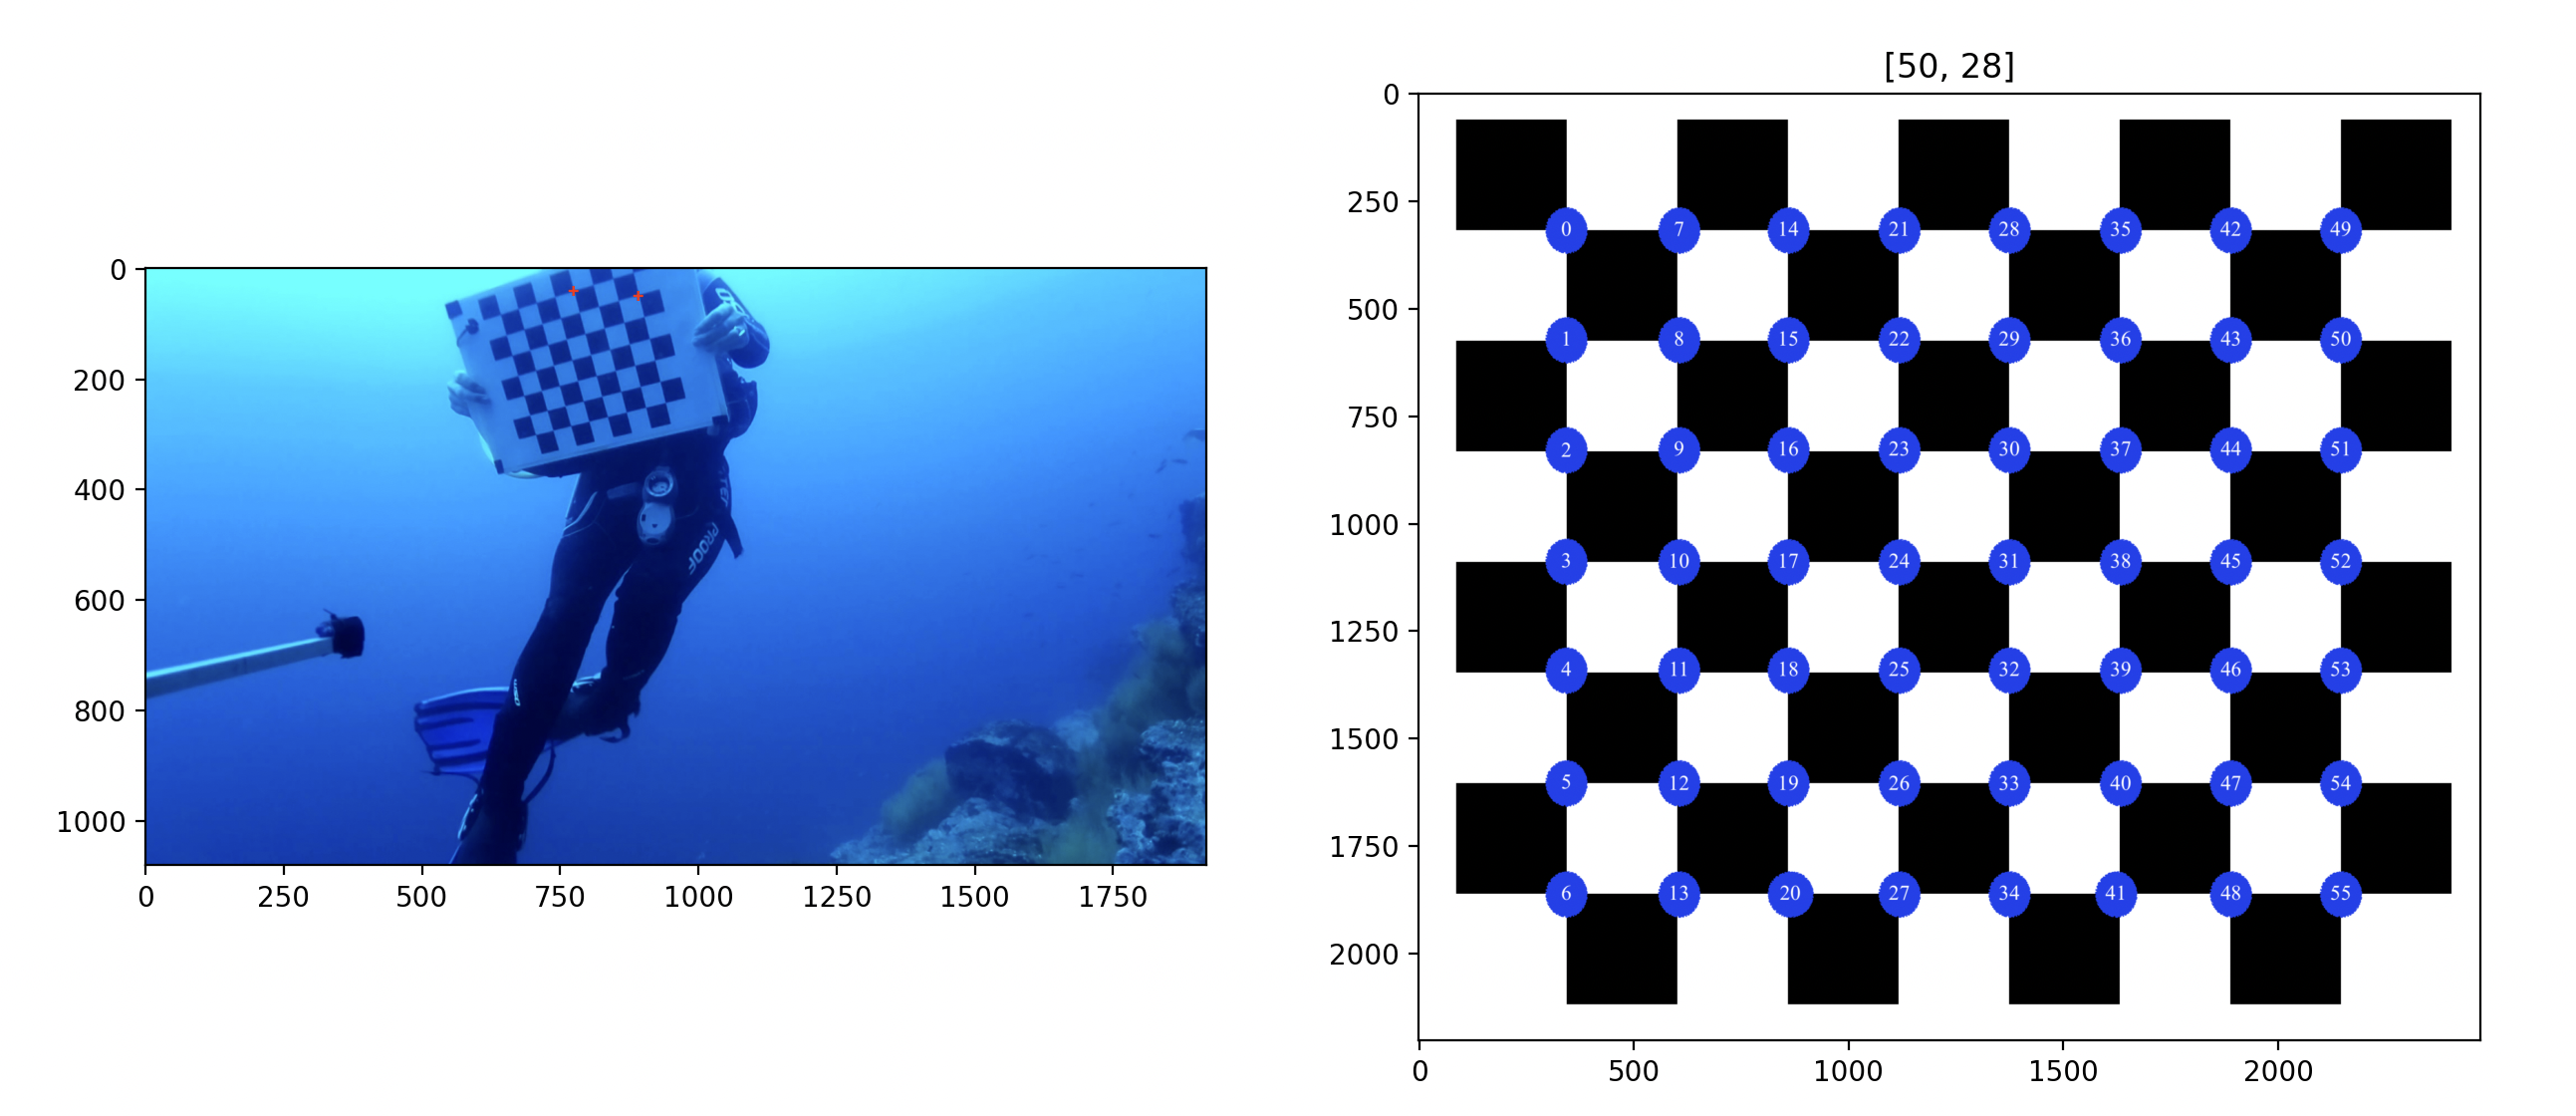

In [26]:
### Select new subset of frames not used in callibration 
frame_sequence=video_fps*5 # one image every 5 seconds

### Select section of video when checkerboard in view. 
#start_time = 0 #time in decimal (e.g. 5 mins 30 seconds = 5.5)
#end_time = 8 #11 mins 15 seconds = 11.5

Frames=create_image_sequence(left_video_path, right_video_path)

In [27]:
### Select a random frame and certain points on checkerboard. Randomly generate points to click. 
###Add point number using reference checkerboard below - update depending on own checkerboard dimensions. 

def generate_random():
    
    rand_frame_name=random.choice(Frames)
    points=(rows*columns)

    point1=random.randint(0,points-1)
    point2=random.randint(0,points-1)
    while point1 == point2:
        point2=random.randint(0,points-1)
    return(point1, point2,rand_frame_name)

#point1, point2,rand_frame_name =  generate_random()

In [28]:
from matplotlib.widgets import Cursor
import keyboard

def check_image(image_path):
    img=cv2.imread(os.path.join(image_path,rand_frame_name))
    cv2.imshow('img', img)
    key = cv2.waitKey(0)

    if key == 27:
        use = False
        cv2.destroyAllWindows()
    else:
        use=True
        cv2.destroyAllWindows()
    return(use)

#use = check_image(left_image_output)
#print(use)

## 27 = escape - press escape if image not suitable i.e. no checkerboard in image

In [29]:
def manually_identify_points(image_path):
    val = rows*columns
    
    matrix=np.arange(0, val, 1).reshape((rows, columns), order="F")
    %matplotlib qt
    reference=cv2.imread('Add_own_file_path/Reference checkerboard.png') 
    #This shows the reference checkerboard and numbered points
    #Reference checkerboard with numbered points (like above) should be made my the user
    img=cv2.imread(os.path.join(image_path,rand_frame_name))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.rcParams["figure.figsize"]=30,30

    plt.subplot(1, 2, 2)
    plt.imshow(reference)
    plt.title([point1, point2])
    plt.rcParams["figure.figsize"]=30,30
    zoom_ok = False 
    print('\nZoom or pan to view, \npress spacebar when ready to click:\n')
    while not zoom_ok:
        zoom_ok = plt.waitforbuttonpress()
    print('Click location of two points in same order each time')
    print(matrix)
    coords = plt.ginput(2, show_clicks=True)
        # print('Selected values: ', val)
    
    plt.close()
    
    return(coords)


In [ ]:
from csv import DictWriter

file= "Add_own_path/Manual_coords.csv"

iteration=0
max=50

while iteration < max-1:

    use = False
    while use == False:
        point1, point2,rand_frame_name =  generate_random()
        use = check_image(left_image_output)

    l_coords=manually_identify_points(left_image_output)
    r_coords=manually_identify_points(right_image_output)
    
    #Undistort and triangulate points
    l_coords_undistort=cv2.undistortPoints(np.array(l_coords), l_mtx, l_dist, P=l_mtx)
    r_coords_undistort=cv2.undistortPoints(np.array(r_coords), r_mtx, r_dist, P=r_mtx)
    projMat1 = l_mtx @ cv2.hconcat([np.eye(3), np.zeros((3,1))]) # Cam1 is the origin
    projMat2 = r_mtx @ cv2.hconcat([R, T]) # R, T from stereoCalibrate
    triangulation = cv2.triangulatePoints(projMat1, projMat2,l_coords_undistort, r_coords_undistort)
    triangulation = (triangulation[:3, :]/triangulation[3, :]).T
    
    #Predicted distance
    point1_coords=np.array([triangulation[0][0], triangulation[0][1], triangulation[0][2]])
    point2_coords=np.array([triangulation[1][0], triangulation[1][1], triangulation[1][2]])
    dist_predicted = np.sum((point1_coords-point2_coords)**2, axis=0)
    dist_predicted=np.sqrt(dist_predicted)
    
    #Actual distance
    val=rows*columns
    matrix=np.arange(0, val, 1).reshape((rows, columns), order="F")
    result = np.where(matrix == point1)
    point_1_cols=result[1]
    point_1_rows=result[0]
    result = np.where(matrix == point2)
    point_2_cols=result[1]
    point_2_rows=result[0]

    row_diff=abs(point_2_rows-point_1_rows)
    col_diff=abs(point_2_cols-point_1_cols)

    actual = (checkerboard_box_size_scale*row_diff[0])**2 + (checkerboard_box_size_scale*col_diff[0])**2
    actual=np.sqrt(actual)
    
    #Save values to datafile
    field_names = ['Video_name', 'Frame_number',"point1", "point2", 'l_point_1_x','l_point_1_y', 'l_point_2_x', 'l_point_2_y', 'r_point_1_x','r_point_1_y', 'r_point_2_x', 'r_point_2_y', 'point1_x', 'point1_y', 'point1_z', 'point2_x', 'point2_y', 'point2_z', 'predicted_distance', 'actual_distance', 'error']
    dict = {'Video_name':video_name, 'Frame_number':rand_frame_name, "point1": point1, "point2":point2, 'l_point_1_x':l_coords[0][0] ,'l_point_1_y':l_coords[0][1], 'l_point_2_x':l_coords[1][0], 
            'l_point_2_y':l_coords[1][1], 'r_point_1_x':r_coords[0][0],'r_point_1_y':r_coords[0][1], 'r_point_2_x':r_coords[1][0], 'r_point_2_y':r_coords[1][1], 
           'point1_x':triangulation[0][0], 'point1_y':triangulation[0][1],'point1_z':triangulation[0][2],
            'point2_x':triangulation[1][0],'point2_y':triangulation[1][1], 'point2_z':triangulation[1][2], 
           'predicted_distance':dist_predicted, 'actual_distance':actual, 'error':abs(dist_predicted-actual)}
    with open(file, 'a') as f_object:
        dictwriter_object = DictWriter(f_object, fieldnames=field_names)
        dictwriter_object.writerow(dict)
        f_object.close()
    iteration=iteration+1